## Preparation

In [1]:
import pyabc
import matplotlib.pyplot as plt
import pickle
import numpy as np
from study_abc_noise.model import (
    ConversionReactionModelVars,
    ConversionReactionLaplaceModelVars,
    HodgkinHuxleyModelVars,
    MRNATranscriptionModelVars,
)
%matplotlib inline

n_data_hh = 100

h_cr = pyabc.History("sqlite:///../application_cr/cr_10_stochacc.db")
h_crl = pyabc.History("sqlite:///../application_cr/cr_laplace_10_stochacc.db")
h_hh = pyabc.History(f"sqlite:///../application_hh/hh_{n_data_hh}_stochacc.db")
h_mrna = pyabc.History("sqlite:///../application_mrna/mrna_10_poisson_stochacc.db")

h_cr_nm = pyabc.History("sqlite:///../application_cr/cr_10_noisymodel.db")
h_crl_nm = pyabc.History("sqlite:///../application_cr/cr_laplace_10_noisymodel.db")
h_hh_nm = pyabc.History(f"sqlite:///../application_hh/hh_{n_data_hh}_noisymodel.db")
h_mrna_nm = pyabc.History("sqlite:///../application_mrna/mrna_10_poisson_noisymodel.db")

h_cr_bc = pyabc.History("sqlite:///../application_cr/cr_10_stochacc_badc.db")
h_crl_bc = pyabc.History("sqlite:///../application_cr/cr_laplace_10_stochacc_badc.db")
h_hh_bc = pyabc.History(f"sqlite:///../application_hh/hh_{n_data_hh}_stochacc_badc.db")
h_mrna_bc = pyabc.History("sqlite:///../application_mrna/mrna_10_poisson_stochacc_badc.db")

h_cr_r = pyabc.History("sqlite:///../application_cr/cr_10_rejection.db")
h_crl_r = pyabc.History("sqlite:///../application_cr/cr_laplace_10_rejection.db")
h_hh_r = pyabc.History(f"sqlite:///../application_hh/hh_{n_data_hh}_rejection.db")
h_mrna_r = pyabc.History("sqlite:///../application_mrna/mrna_10_poisson_rejection.db")

h_cr_rbc = pyabc.History("sqlite:///../application_cr/cr_10_rejection_badc.db")
h_crl_rbc = pyabc.History("sqlite:///../application_cr/cr_laplace_10_rejection_badc.db")
h_hh_rbc = pyabc.History(f"sqlite:///../application_hh/hh_{n_data_hh}_rejection_badc.db")
h_mrna_rbc = pyabc.History("sqlite:///../application_mrna/mrna_10_poisson_rejection_badc.db")

mv_cr = ConversionReactionModelVars(n_t=10)
data_true_cr = mv_cr.get_model()(mv_cr.p_true)
times_cr = mv_cr.get_ts()
mv_crl = ConversionReactionLaplaceModelVars(n_t=10)
data_true_crl = mv_crl.get_model()(mv_crl.p_true)
times_crl = mv_crl.get_ts()
mv_hh = HodgkinHuxleyModelVars(n_t=n_data_hh)
data_true_hh = pickle.load(open(f"data_hh/data_{n_data_hh}.p", 'rb'))[0]
times_hh = mv_hh.get_obs_times()
mv_mrna = MRNATranscriptionModelVars(n_t=10, noise_model='poisson')
data_true_mrna = pickle.load(open("data_mrna/data_10_poisson.p", 'rb'))[0]
times_mrna = data_true_mrna['t']

hs = [h_cr, h_crl, h_hh, h_mrna]
hs_nm = [h_cr_nm, h_crl_nm, h_hh_nm, h_mrna_nm]
hs_bc = [h_cr_bc, h_crl_bc, h_hh_bc, h_mrna_bc]
hs_r = [h_cr_r, h_crl_r, h_hh_r, h_mrna_r]
hs_rbc = [h_cr_rbc, h_crl_rbc, h_hh_rbc, h_mrna_rbc]

arr_hs = [hs, hs_nm, hs_bc, hs_r, hs_rbc]
method_ids = ["stochacc", "noisymodel", "stochabb_bc", "rejection", "rejection_bc"]

method_labels = ["ASSA", "Noisy model", "ASSA, $c_t=\hat c$",
                 "ASSA, $n_t=1$", "ASSA, $n_t=1$, $c_t=\hat c$"]


mvs = [mv_cr, mv_crl, mv_hh, mv_mrna]
model_ids = ["M1", "M2", "M3", "M4"]

datas = [h.observed_sum_stat() for h in hs]
data_cr, data_crl, data_hh, data_mrna = datas

# does not work for some reason from history
data_hh = pickle.load(open(f"../application_hh/data/data_{n_data_hh}.p", 'rb'))[1]
datas[2] = data_hh

## Data

dict_keys(['growth_curve', 'extra_cellular_matrix_profile', 'proliferation_profile'])


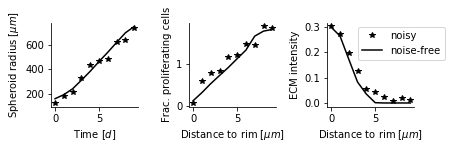

In [2]:
exact_data = pickle.load(open('../application_tumor/exact_data_v5.dat', 'rb'))
noisy_data = pickle.load(open('../application_tumor/noisy_data_v5.dat', 'rb'))

print(exact_data.keys())

data_ylabels = ["Spheroid radius [$\\mu m$]", "Frac. proliferating cells", "ECM intensity"]
data_xlabels = ["Time [$d$]", "Distance to rim [$\\mu m$]", "Distance to rim [$\\mu m$]"]

fig, arr_ax = plt.subplots(1,3)
for i, key in enumerate(exact_data.keys()):
    arr_ax[i].plot(noisy_data[key], '*', label='noisy', color='k')
    arr_ax[i].plot(exact_data[key], '-', label='noise-free', color='k')
    arr_ax[i].set_ylabel(data_ylabels[i])
    arr_ax[i].set_xlabel(data_xlabels[i])
    arr_ax[i].spines['right'].set_visible(False)
    arr_ax[i].spines['top'].set_visible(False)
fig.set_size_inches((6, 2))
fig.tight_layout()
arr_ax[2].legend(loc="lower left", bbox_to_anchor=(0.3,0.5))

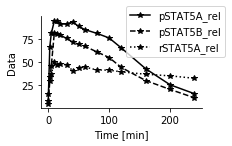

In [3]:
import pypesto

importer = pypesto.PetabImporter.from_folder("../model/Boehm_JProteomeRes2014")
problem = importer.petab_problem
data = {}
df = problem.measurement_df
for obsId in np.unique(df['observableId']):
    data[obsId] = df[df['observableId']==obsId][['time', 'measurement']]
fig, ax = plt.subplots()
for obsId, linestyle in zip(data, ['-', 'dashed', 'dotted']):
    ax.plot(data[obsId]['time'], data[obsId]['measurement'], color='k', linestyle=linestyle, marker='*', label=obsId)

ax.set_xlabel("Time [min]")
ax.set_ylabel("Data")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches((3,2))
fig.tight_layout()
ax.legend(loc="lower left", bbox_to_anchor=(0.5,0.5))

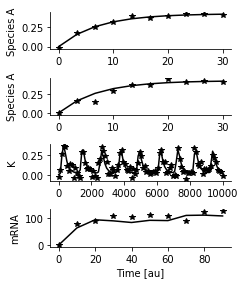

In [4]:
fig, arr_ax = plt.subplots(4,1)

arr_ax[0].plot(times_cr, data_true_cr['y'], color='k')
arr_ax[0].plot(times_cr, data_cr['y'], '*', color='k')
arr_ax[0].set_ylabel("Species A")

arr_ax[1].plot(times_crl, data_true_crl['y'], color='k')
arr_ax[1].plot(times_crl, data_crl['y'], '*', color='k')
arr_ax[1].set_ylabel("Species A")

arr_ax[2].plot(times_hh, data_true_hh['K'], color='k')
arr_ax[2].plot(times_hh, data_hh['K'], '*', color='k')
arr_ax[2].set_ylabel("K")

arr_ax[3].plot(times_mrna, data_true_mrna['mrna'], color='k')
arr_ax[3].plot(times_mrna, data_mrna['mrna'], '*', color='k')
arr_ax[3].set_ylabel("mRNA")
arr_ax[3].set_xlabel("Time [au]")

for ax in arr_ax:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.set_size_inches((3.5, 4))
fig.tight_layout()

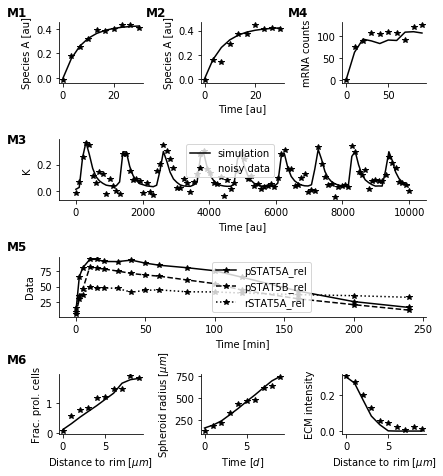

In [5]:
fig = plt.figure()

ax0 = plt.subplot2grid((4,3), (0,0), colspan=1)
ax0.plot(times_cr, data_true_cr['y'], color='k')
ax0.plot(times_cr, data_cr['y'], '*', color='k')
ax0.set_ylabel("Species A [au]")

ax1 = plt.subplot2grid((4,3), (0,1), colspan=1)
ax1.plot(times_cr, data_true_crl['y'], color='k')
ax1.plot(times_cr, data_crl['y'], '*', color='k')
ax1.set_ylabel("Species A [au]")
ax1.set_xlabel("Time [au]")

ax2 = plt.subplot2grid((4,3), (1,0), colspan=3)
ax2.plot(times_hh, data_true_hh['K'], color='k', label="simulation")
ax2.plot(times_hh, data_hh['K'], '*', color='k', label="noisy data")
ax2.set_ylabel("K")
ax2.set_xlabel("Time [au]")
ax2.legend(loc="upper right", bbox_to_anchor=(0.6,1))

ax3 = plt.subplot2grid((4,3), (0,2), colspan=1)
ax3.plot(times_mrna, data_true_mrna['mrna'], color='k')
ax3.plot(times_mrna, data_mrna['mrna'], '*', color='k')
ax3.set_ylabel("mRNA counts")

ax4 = plt.subplot2grid((4,3), (2,0), colspan=3)
for obsId, linestyle in zip(data, ['-', 'dashed', 'dotted']):
    ax4.plot(data[obsId]['time'], data[obsId]['measurement'], color='k', linestyle=linestyle, marker='*', label=obsId)
ax4.set_xlabel("Time [min]")
ax4.set_ylabel("Data")
ax4.legend(loc="upper right", bbox_to_anchor=(0.7,1))

data_ylabels = ["Frac. prol. cells", "Spheroid radius [$\\mu m$]", "ECM intensity"]
data_xlabels = ["Distance to rim [$\\mu m$]", "Time [$d$]", "Distance to rim [$\\mu m$]"]
for i, key in enumerate(['extra_cellular_matrix_profile', 'growth_curve', 'proliferation_profile']):
    ax = plt.subplot2grid((4,3), (3,i), colspan=1)
    ax.plot(noisy_data[key], '*', label='noisy', color='k')
    ax.plot(exact_data[key], '-', label='noise-free', color='k')
    ax.set_ylabel(data_ylabels[i])
    ax.set_xlabel(data_xlabels[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#ax.legend(loc="lower left", bbox_to_anchor=(0.2,0.5))

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
# add identifiers
plt.figtext(-0.01, 0.99, "M1", size=12, weight='bold')
plt.figtext(0.31, 0.99, "M2", size=12, weight='bold')
plt.figtext(0.64, 0.99, "M4", size=12, weight='bold')
plt.figtext(-0.01, 0.72, "M3", size=12, weight='bold')
plt.figtext(-0.01, 0.49, "M5", size=12, weight='bold')
plt.figtext(-0.01, 0.25, "M6", size=12, weight='bold')

fig.set_size_inches((6,6.5))
#fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"data_combined.{fmt}", format=fmt)

## Posteriors

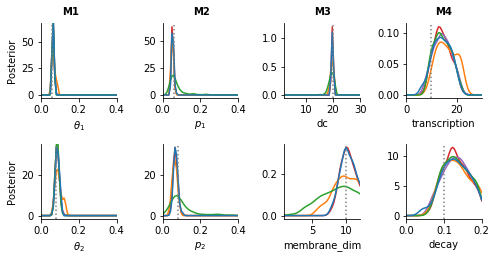

In [6]:
from matplotlib.lines import Line2D

fig, arr_ax = plt.subplots(2,4)
for j, (h, h_nm, h_r, h_rbc, h_bc, mv) in enumerate(zip(hs, hs_nm, hs_r, hs_rbc, hs_bc, mvs)):
    for ip, p in enumerate(mv.p_true):
        ax = arr_ax[ip][j]
        pyabc.visualization.plot_kde_1d_highlevel(
            h_r, x=p, xmin=mv.limits[p][0],
            xmax=mv.limits[p][1], ax=ax,
            label="Stochastic acceptor, $n_t=1$", color='C3')
        if h_rbc.max_t >= 0:
            pyabc.visualization.plot_kde_1d_highlevel(
                h_rbc, x=p, xmin=mv.limits[p][0],
                xmax=mv.limits[p][1], ax=ax,
                label="Stochastic acceptor, $n_t=1, $c_t=\overline{c}$", color='C4')
        pyabc.visualization.plot_kde_1d_highlevel(
            h_nm, x=p, xmin=mv.limits[p][0],
            xmax=mv.limits[p][1], ax=ax,
            label="Noisy model", color='C1')
        pyabc.visualization.plot_kde_1d_highlevel(
            h_bc, x=p, xmin=mv.limits[p][0],
            xmax=mv.limits[p][1], ax=ax,
            label="Stochastic acceptor, $c_t=\overline{c}$", color='C2')
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0],
            refval=mv.p_true, refval_color='grey', 
            xmax=mv.limits[p][1], ax=ax,
            label="Stochastic acceptor", color='C0')
        if j > 0: ax.set_ylabel(None)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.relim()
        ax.autoscale_view()
        ax.set_ylim()
arr_ax[0][0].set_xlabel("$\\theta_1$")
arr_ax[1][0].set_xlabel("$\\theta_2$")
arr_ax[0][1].set_xlabel("$p_1$")
arr_ax[1][1].set_xlabel("$p_2$")
#_handles, _labels = arr_ax[0][0].get_legend_handles_labels()
#_ind = [4,1,2,0,3]
#_handles = [_handles[i] for i in _ind]
#_labels = [_labels[i] for i in _ind]
#arr_ax[0, 0].legend(_handles, _labels, loc="lower left", bbox_to_anchor=(0, 1.1))

#arr_ax[0,0].add_artist(plt.Circle((1, 1), 0.2, color='r'))

# add identifiers
plt.figtext(0.13, 0.99, "M1", size=10, weight='bold')
plt.figtext(0.39, 0.99, "M2", size=10, weight='bold')
plt.figtext(0.63, 0.99, "M3", size=10, weight='bold')
plt.figtext(0.87, 0.99, "M4", size=10, weight='bold')

custom_lines = [Line2D([0], [0], color='C0', lw=4),
                Line2D([0], [0], color='C1', lw=4),
                Line2D([0], [0], color='C2', lw=4),
                Line2D([0], [0], color='C3', lw=4),
                Line2D([0], [0], color='C4', lw=4)]
#arr_ax[0, 1].legend(custom_lines, method_labels, loc="upper left", bbox_to_anchor=(1, 1.1))

fig.set_size_inches((7, 3.5))
fig.tight_layout()
#plt.show()

for fmt in ['svg', 'eps']:
    plt.savefig(f"posteriors.{fmt}", format=fmt)

## Intermediate stuff

[268489, 560440, 732458]


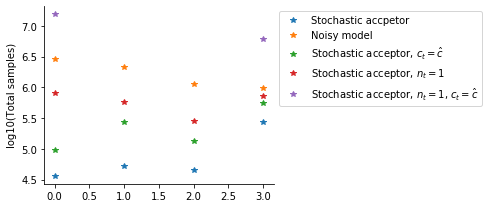

In [7]:
samples = [sum(h.get_all_populations()['samples']) for h in hs]
samples_nm = [sum(h.get_all_populations()['samples']) for h in hs_nm]
samples_bc = [sum(h.get_all_populations()['samples']) for h in hs_bc]
samples_r = [sum(h.get_all_populations()['samples']) for h in hs_r]
samples_rbc = [sum(h.get_all_populations()['samples']) for h in hs_rbc]

labels = ["Stochastic accpetor", "Noisy model", "Stochastic acceptor, $c_t=\hat c$", "Stochastic acceptor, $n_t=1$", "Stochastic acceptor, $n_t=1$, $c_t=\hat c$"]

arr_samples = [samples, samples_nm, samples_bc, samples_r, samples_rbc]

fig, ax = plt.subplots()
for _samples, label in zip(arr_samples, labels):
    _samples = np.array(_samples, dtype=float)
    _samples[_samples == 0] = np.inf
    ax.plot(np.log10(_samples), '*', label=label)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("log10(Total samples)")
fig.set_size_inches((4,3))
fig.tight_layout()
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

print([sum(_h.get_all_populations()['samples']) for _h in [h_mrna, h_mrna_bc, h_mrna_r]])


In [84]:
print(samples[0], samples_bc[0])

36431 95273


## Effective sample sizes

In [8]:
ess = []
for ihs, _hs in enumerate([hs, hs_nm, hs_bc, hs_r, hs_rbc]):
    es = []
    ess.append(es)
    for _h in _hs:
        if len(np.array(_h.get_all_populations()['epsilon'])) > 1:
            #if ihs != 1 and np.array(_h.get_all_populations()['epsilon'])[-1] == 1:
            df, w = _h.get_distribution()
            e = pyabc.weighted_statistics.effective_sample_size(w)
            #else:
            #    e = 0
        else:
            e = 0
        es.append(e)
        

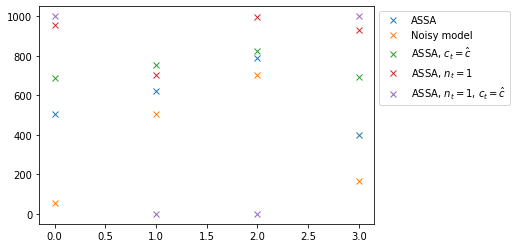

In [9]:
for es, label in zip(ess, method_labels):
    plt.plot(es, 'x', label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))


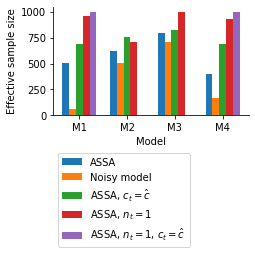

In [10]:
fig, ax = plt.subplots()

n_method = len(ess)
n_model = len(model_ids)
x = np.arange(n_model)
barwidth = 1 / (n_method + 2)

for i_method, es in enumerate(ess):
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    ax.bar(x, es, width=barwidth, label=method_labels[i_method], color=f'C{i_method}')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,11)
ax.set_ylabel("Effective sample size")
ax.set_xticks(np.arange(n_model))
ax.set_xticklabels(model_ids)
ax.set_xlabel("Model")

ax.legend(loc="upper left", bbox_to_anchor=(0,-0.3))

fig.set_size_inches((3.5,2))

for fmt in ['svg']:
    plt.savefig(f"ess.{fmt}", format=fmt)

## Renormalized effective sample sizes

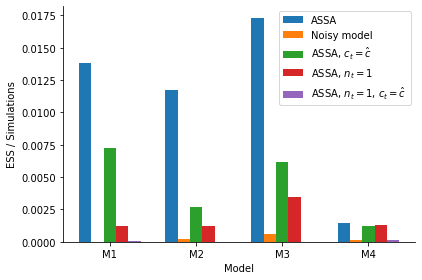

In [11]:
n_model = 4
barwidth = 1 / (n_method + 2)

fig, ax = plt.subplots()

for i_method, (_samples, es) in enumerate(zip(arr_samples, ess)):
    _samples = np.array(_samples, dtype=float)
    es = np.array(es, dtype=float)
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    _samples[_samples == 0] = np.inf
    es_by_samples = es / _samples
    ax.bar(x, es_by_samples, width=barwidth, label=method_labels[i_method], color=f'C{i_method}')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0,11)
ax.set_ylabel("ESS / Simulations")
ax.set_xticks(np.arange(n_model))
ax.set_xticklabels(model_ids)
ax.set_xlabel("Model")
ax.legend(loc="upper left", bbox_to_anchor=(0.6,1))

fig.set_size_inches((6,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"ess_renorm.{fmt}", format=fmt)

/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


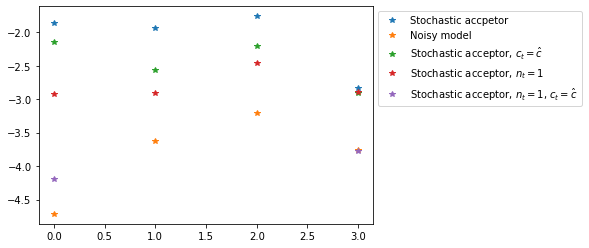

In [72]:
fig, ax = plt.subplots()

for _samples, es, label in zip(arr_samples, ess, labels):
    _samples = np.array(_samples, dtype=float)
    _samples[_samples == 0] = np.inf
    ax.plot(es / _samples, '*', label=label)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))

This is to extract the total numbers of samples in the databases.

## Samples

In [103]:
import pandas as pd

_lst = []
for _hs, method_id in zip(arr_hs, method_ids):
    for _h, model_id in zip(_hs, model_ids):
        samples = np.array(_h.get_all_populations()['samples'])
        _lst.append({'method_id': method_id, 'model_id': model_id,
                     'total_samples': sum(samples), 'last_iter_samples': samples[-1]})
        
df = pd.DataFrame(_lst)
df.sort_values(by=['model_id'])



,method_id,model_id,total_samples,last_iter_samples
0,stochacc,M1,36431,2212
16,rejection_bc,M1,15396330,15396330
4,noisymodel,M1,2912814,1387405
12,rejection,M1,800765,799765
8,stochabb_bc,M1,95273,25689
17,rejection_bc,M2,0,0
13,rejection,M2,578643,577643
9,stochabb_bc,M2,277684,211696
5,noisymodel,M2,2161951,975445
1,stochacc,M2,52904,3999


This is to predict the number of samples in the last iteration using $c=\bar c$ (results often not available) from the results using the adaptive $c$, according to

$$s_{pred, \bar c} = \frac{\bar c}{c}s_{c}$$

where $s$ denotes the numbers of samples in the last iteration.

In [104]:
import os
import copy

_lst_prediction = []

c_bars = []
#print(mvs, datas)
for _mv, _data in zip(mvs, datas):
    _kernel = _mv.get_kernel()
    _kernel.initialize(0, None, _data)
    c_bars.append(_kernel.pdf_max)

for i, (mt, nt, c_bar) in enumerate(zip(['cr', 'cr', 'hh', 'mrna'], [10, 10, n_data_hh, 10], c_bars)):
    basedir = f"../application_{mt}/log/"
    for f in os.listdir(basedir):
        if "acceptor" not in f or f"_{nt}_" not in f or ("mrna" in f and "poisson" not in f):
            continue
        if i == 0 and "laplace" in f:
            continue
        if i == 1 and "laplace" not in f:
            continue
        if "badc" in f:
            continue

        dct = pyabc.storage.load_dict_from_json(basedir + f)
        last_c = dct[max(dct.keys())]
        if "cr" in f:
            if "laplace" in f:
                model_id = 'M2'
            else:
                model_id = 'M1'
        elif "hh" in f:
            model_id = 'M3'
        else:
            model_id = 'M4'

        if "stochacc" in f:
            method_id = 'stochacc'
        elif "rejection" in f:
            method_id = 'rejection'

        last_iter_base = float(df[(df[['method_id', 'model_id']] == \
            [method_id, model_id]).all(1)]['last_iter_samples'])
        samples_prediction = float(np.exp(c_bar - last_c) * last_iter_base)
        _lst_prediction.append({'method_id': method_id + "_bc", 'model_id': model_id,
                                'last_c': last_c, 'c_bar': c_bar,
                                'samples_prediction': samples_prediction, 'last_iter_c': last_iter_base})
        #print(f)
        #print(last_c, c_bar, last_iter_base)
        #print(samples_prediction)
        
    
#cr_kernel = mv_cr.get_kernel()
#cr_kernel.initialize(0, None, data_cr)
#print(cr_kernel.pdf_max)

df_prediction = pd.DataFrame(_lst_prediction)

np.log10(df_prediction['samples_prediction'])

print(np.log10(df_prediction['samples_prediction']))
df_prediction

0     4.359339
1     6.917626
2     8.382333
3    10.556669
4    23.800392
5    25.576308
6     5.424197
7     6.127609
Name: samples_prediction, dtype: float64


,method_id,model_id,last_c,c_bar,samples_prediction,last_iter_c
0,stochacc_bc,M1,27.594747,29.930845,2.287386e+04,2212.0
1,rejection_bc,M1,27.594496,29.930845,8.272291e+06,799765.0
2,stochacc_bc,M2,21.181522,32.188758,2.411756e+08,3999.0
3,rejection_bc,M2,21.147841,32.188758,3.603040e+10,577643.0
4,stochacc_bc,M3,161.342426,207.679374,6.315267e+23,4748.0
5,rejection_bc,M3,161.342455,207.679374,3.769710e+25,283426.0
6,stochacc_bc,M4,-29.525848,-29.094784,2.655808e+05,172579.0
7,rejection_bc,M4,-29.701329,-29.094784,1.341555e+06,731458.0


Plot everything.

/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10


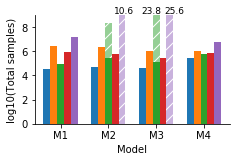

In [105]:
# see https://matplotlib.org/examples/pylab_examples/broken_axis.html

#method_ids = ['stochacc_bc', 'rejection', 'rejection_bc', 'noisymodel', 'stochacc']
method_labels = ["Stochastic accpetor", "Noisy model", "Stochastic acceptor, $c_t=\overline{c}$",
                 "Stochastic acceptor, $n_t=1$", "Stochastic acceptor, $n_t=1$, $c_t=\overline{c}$"]

#model_ids = ['M1', 'M2', 'M3', 'M4']
plt.rcParams.update({'hatch.color': 'white'})

arr_real_samples = []
for method in method_ids:
    real_samples = []
    for model in model_ids:
        row = df[(df[['method_id', 'model_id']] == [method, model]).all(1)]
        real_samples.append(float(row['total_samples']))
    arr_real_samples.append(real_samples)
    
arr_predictions = []
for method in ['stochacc_bc', 'rejection_bc']:
    predictions = []
    for model in model_ids:
        row = df_prediction[(df_prediction[['method_id', 'model_id']] == [method, model]).all(1)]
        predictions.append(float(row['samples_prediction']))
    arr_predictions.append(predictions)
x_ids = [2,4]

fig, ax = plt.subplots()

n_method = len(arr_real_samples)
n_model = len(model_ids)
x = np.arange(n_model)
barwidth = 1 / (n_method + 2)

for i_method, predictions in zip([2,4], arr_predictions):
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    ax.bar(x, np.log10(predictions), width=barwidth, alpha=0.5, color=f'C{i_method}', hatch='//')

for i_method, real_samples in enumerate(arr_real_samples):
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    ax.bar(x, np.log10(real_samples), width=barwidth, label=method_labels[i_method], color=f'C{i_method}')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,9)
ax.set_ylabel("log10(Total samples)")
ax.set_xticks(np.arange(n_model))
ax.set_xticklabels(model_ids)
ax.set_xlabel("Model")

plt.figtext(0.44, 0.89, "10.6", size=9)
plt.figtext(0.55, 0.89, "23.8", size=9)
plt.figtext(0.64, 0.89, "25.6", size=9)

fig.set_size_inches((3.5,2))

#ax.legend(loc="upper left", bbox_to_anchor=(1,1))

for fmt in ['svg']:
    plt.savefig(f"total_samples.{fmt}", format=fmt)

/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


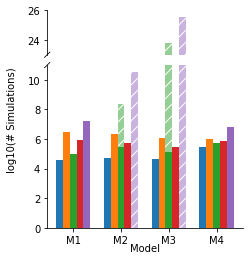

In [106]:
# see https://matplotlib.org/examples/pylab_examples/broken_axis.html
from brokenaxes import brokenaxes

#method_ids = ['stochacc_bc', 'rejection', 'rejection_bc', 'noisymodel', 'stochacc']
method_labels = ["Stochastic accpetor", "Noisy model", "Stochastic acceptor, $c_t=\overline{c}$",
                 "Stochastic acceptor, $n_t=1$", "Stochastic acceptor, $n_t=1$, $c_t=\overline{c}$"]

#model_ids = ['M1', 'M2', 'M3', 'M4']
plt.rcParams.update({'hatch.color': 'white'})

arr_real_samples = []
for method in method_ids:
    real_samples = []
    for model in model_ids:
        row = df[(df[['method_id', 'model_id']] == [method, model]).all(1)]
        real_samples.append(float(row['total_samples']))
    arr_real_samples.append(real_samples)
    
arr_predictions = []
for method in ['stochacc_bc', 'rejection_bc']:
    predictions = []
    for model in model_ids:
        row = df_prediction[(df_prediction[['method_id', 'model_id']] == [method, model]).all(1)]
        predictions.append(float(row['samples_prediction']))
    arr_predictions.append(predictions)
x_ids = [2,4]

fig = plt.figure()

fig.set_size_inches((3.5,4))
ax = brokenaxes(ylims=((0, 11), (23, 26)), hspace=.1)


n_method = len(arr_real_samples)
n_model = len(model_ids)
x = np.arange(n_model)
barwidth = 1 / (n_method + 2)

for i_method, predictions in zip([2,4], arr_predictions):
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    ax.bar(x, np.log10(predictions), width=barwidth, alpha=0.5, color=f'C{i_method}', hatch='//')

for i_method, real_samples in enumerate(arr_real_samples):
    x = np.arange(n_model) + (i_method+0.5-n_method/2) * barwidth
    ax.bar(x, np.log10(real_samples), width=barwidth, label=method_labels[i_method], color=f'C{i_method}')

#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.set_ylim(0,11)
ax.set_ylabel("log10(# Simulations)")
ax.set_xlabel("Model")

#ax.set_xticks(np.arange(n_model))
ax.set_xticklabels(["", *model_ids])

#ax.legend(loc="upper left", bbox_to_anchor=(1,1))

for fmt in ['svg']:
    plt.savefig(f"total_samples_brokenaxes.{fmt}", format=fmt)

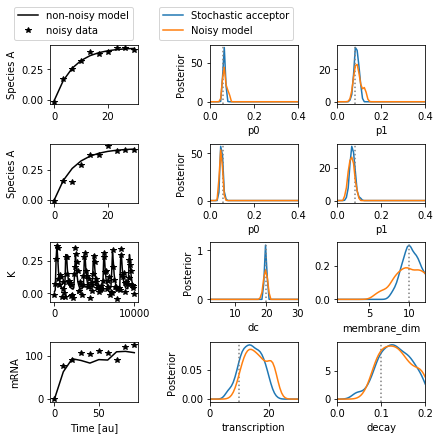

In [126]:
# combined

fig, arr_ax = plt.subplots(4,3, constrained_layout=True)

arr_ax[0][0].plot(times_cr, data_true_cr['y'], color='k', label="non-noisy model")
arr_ax[0][0].plot(times_cr, data_cr['y'], '*', color='k', label="noisy data")
arr_ax[0][0].set_ylabel("Species A")

arr_ax[1][0].plot(times_crl, data_true_crl['y'], color='k')
arr_ax[1][0].plot(times_crl, data_crl['y'], '*', color='k')
arr_ax[1][0].set_ylabel("Species A")

arr_ax[2][0].plot(times_hh, data_true_hh['K'], color='k')
arr_ax[2][0].plot(times_hh, data_hh['K'], '*', color='k')
arr_ax[2][0].set_ylabel("K")

arr_ax[3][0].plot(times_mrna, data_true_mrna['mrna'], color='k')
arr_ax[3][0].plot(times_mrna, data_mrna['mrna'], '*', color='k')
arr_ax[3][0].set_ylabel("mRNA")

arr_ax[3][0].set_xlabel("Time [au]")

for j, (h, h_nm, mv) in enumerate(zip(hs, hs_nm, mvs)):
    for ip, p in enumerate(mv.p_true):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0],
            refval=mv.p_true, refval_color='grey', 
            xmax=mv.limits[p][1], ax=arr_ax[j][ip+1],
            label="Stochastic acceptor")
        pyabc.visualization.plot_kde_1d_highlevel(
            h_nm, x=p, xmin=mv.limits[p][0],
            xmax=mv.limits[p][1], ax=arr_ax[j][ip+1],
            label="Noisy model")
        if ip == 1: arr_ax[j][ip+1].set_ylabel(None)
fig.set_size_inches((6, 6))
#fig.tight_layout()
#fig.subplots_adjust(wspace=0.5, hspace=0.5)
arr_ax[0, 0].legend(loc="lower right", bbox_to_anchor=(1,1))
arr_ax[0, 1].legend(loc="lower right", bbox_to_anchor=(1,1))

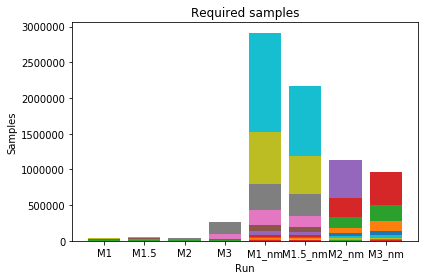

In [93]:
pyabc.visualization.plot_sample_numbers(
    [*hs, *hs_nm], [*labels, *[l + "_nm" for l in labels]])

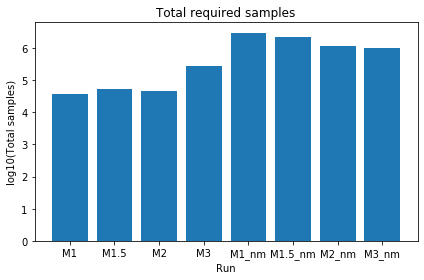

In [94]:
pyabc.visualization.plot_total_sample_numbers(
    [*hs, *hs_nm], [*labels, *[l + "_nm" for l in labels]], yscale='log10')

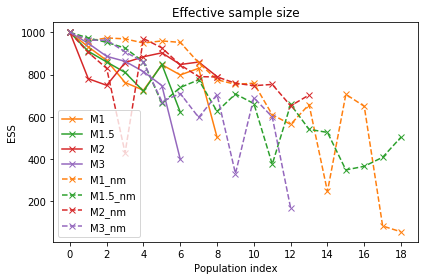

In [97]:
pyabc.visualization.plot_effective_sample_sizes(
    [*hs, *hs_nm], [*labels, *[l + "_nm" for l in labels]])
ax = plt.gca()
lines = ax.get_lines()
lines[0].set_color('C1')
lines[1].set_color('C2')
lines[2].set_color('C3')
lines[3].set_color('C4')
lines[4].set_color('C1')
lines[5].set_color('C2')
lines[6].set_color('C3')
lines[7].set_color('C4')
lines[4].set_linestyle('dashed')
lines[5].set_linestyle('dashed')
lines[6].set_linestyle('dashed')
lines[7].set_linestyle('dashed')
ax.legend()

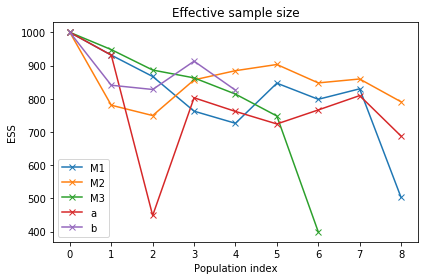

In [81]:
pyabc.visualization.plot_effective_sample_sizes(
    [*hs, *hs_bc], [*labels, 'a', 'b'])
ax = plt.gca()
ax.legend()

In [127]:
import os
for file in os.listdir("."):
    if file.endswith(".db"):
        h = pyabc.History("sqlite:///" + file)
        print(file + ": ", sum(h.get_all_populations()['samples']))

cr_laplace_10_rejection_badc.db:  0
mrna_10_poisson_noisymodel.db:  968749
mrna_10_poisson_stochacc.db:  268489
cr_laplace_10_rejection.db:  578643
hh_100_noisymodel.db:  1134336
hh_100_stochacc_badc.db:  134668
cr_laplace_10_stochacc_badc.db:  277684
hh_30_rejection.db:  237211
hh_30_rejection_badc.db:  0
cr_10_stochacc_badc.db:  95273
mrna_10_poisson_rejection.db:  732458
hh_30_noisymodel.db:  1284295
hh_30_stochacc.db:  63015
cr_10_rejection_badc.db:  0
hh_100_stochacc.db:  45630
hh_100_rejection_badc.db:  0
mrna_10_poisson_stochacc_badc.db:  728273
hh_30_stochacc_badc.db:  464340
cr_10_stochacc.db:  36431
cr_laplace_10_noisymodel.db:  2161951
hh_100_rejection.db:  284426
cr_10_noisymodel.db:  2912814
cr_laplace_10_stochacc.db:  52904
cr_10_rejection.db:  800765
mrna_10_poisson_rejection_badc.db:  0
